Pada Submission ini saya menggunakan dataset yang saya kumpulkan dari kaggle dan hasil scrapping saya sendiri. dimana awalnya data hanya berisi Anjing dan Kucing saya menambahkan kupu-kupu untuk memenuhi saran yang diberikan.

1. import Library yang dibutuhkan untuk pembuatan model.

In [ ]:
import os
import shutil
import random
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from collections import Counter
from PIL import Image
from tensorflow.keras.layers import Input
import matplotlib.image as mpimg

2. Melakukan Split data pada dataset sebagai Train, Val, dan Test dengan perbandingan 8:1:1

Kriteria 3: Dataset Dibagi Menjadi Train Set, Test Set dan Validation Set.

In [ ]:
# Konfigurasi
source_dir = 'dataset'  # Folder asal gambar, berisi subfolder per kelas
output_dir = 'dataset_master'  # Folder output (akan berisi train/val/test)
split_ratio = (0.8, 0.1, 0.1)  # Train, Val, Test

# Buat folder train/val/test
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(source_dir):
        os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# Proses split per kelas
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_end = int(split_ratio[0] * total)
    val_end = train_end + int(split_ratio[1] * total)

    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    for image_name in tqdm(train_images, desc=f'Train {class_name}'):
        shutil.copy2(os.path.join(class_path, image_name), os.path.join(output_dir, 'train', class_name))

    for image_name in tqdm(val_images, desc=f'Val {class_name}'):
        shutil.copy2(os.path.join(class_path, image_name), os.path.join(output_dir, 'val', class_name))

    for image_name in tqdm(test_images, desc=f'Test {class_name}'):
        shutil.copy2(os.path.join(class_path, image_name), os.path.join(output_dir, 'test', class_name))

print("✅ Split selesai!")


Test dogs: 100%|███████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1005.78it/s]

✅ Split selesai!


3. Penamaan yang terstruktur untuk setiap label gambar pada data training, valuation dan test.

In [ ]:
import os

def rename_files(folder_path, class_names):
    for subset in ['train', 'val', 'test']:
        for class_name in class_names:
            class_folder = os.path.join(folder_path, subset, class_name)
            if not os.path.exists(class_folder):
                print(f"Folder {class_folder} tidak ditemukan.")
                continue

            for i, filename in enumerate(sorted(os.listdir(class_folder))):
                ext = os.path.splitext(filename)[1]
                new_filename = f"{class_name}_{i+1:04d}{ext}"
                old_path = os.path.join(class_folder, filename)
                new_path = os.path.join(class_folder, new_filename)
                os.rename(old_path, new_path)

    print("✅ Semua file telah di-rename dengan nama unik!")

# Ganti path ini dengan path dataset kamu
dataset_path = 'dataset_master'
class_names = ['cats', 'dogs', 'Butterfly']

rename_files(dataset_path, class_names)

✅ Semua file telah di-rename dengan nama unik!


4. Melihat ragam resolusi dari data images sebelum preprocessing.

Gambar-gambar pada dataset asli memiliki resolusi yang tidak seragam (Tanpa preprocessing)

Jumlah gambar per resolusi:
Ukuran (224, 224): 5000 gambar
Ukuran (500, 374): 1181 gambar
Ukuran (288, 287): 1 gambar
Ukuran (437, 396): 1 gambar
Ukuran (229, 254): 1 gambar
Ukuran (482, 465): 1 gambar
Ukuran (382, 500): 3 gambar
Ukuran (329, 245): 1 gambar
Ukuran (499, 375): 1163 gambar
Ukuran (349, 206): 2 gambar
Ukuran (299, 356): 1 gambar
Ukuran (462, 445): 1 gambar
Ukuran (340, 499): 3 gambar
Ukuran (450, 337): 3 gambar
Ukuran (500, 371): 7 gambar
Ukuran (488, 500): 4 gambar
Ukuran (479, 430): 2 gambar
Ukuran (235, 448): 1 gambar
Ukuran (499, 448): 4 gambar
Ukuran (277, 322): 1 gambar
Ukuran (320, 239): 86 gambar
Ukuran (359, 270): 15 gambar
Ukuran (499, 319): 6 gambar
Ukuran (499, 435): 4 gambar
Ukuran (149, 140): 1 gambar
Ukuran (319, 240): 85 gambar
Ukuran (499, 333): 99 gambar
Ukuran (279, 274): 1 gambar
Ukuran (288, 215): 4 gambar
Ukuran (499, 451): 5 gambar
Ukuran (495, 500): 1 gambar
Ukuran (480, 359): 34 gambar
Ukuran (355, 403): 1 gambar
Ukuran (250, 187): 5 gambar
Ukuran

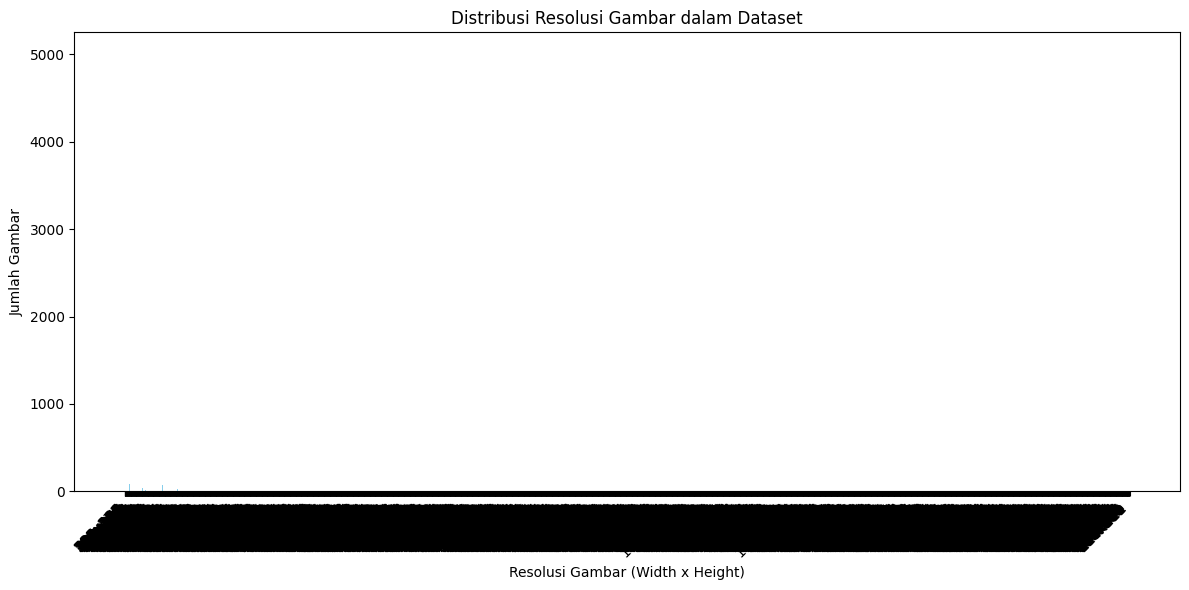

In [ ]:
# Ganti dengan path dataset kamu
dataset_path = 'dataset_master'

# Kumpulkan semua ukuran gambar
image_sizes = []

for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, file)
            try:
                with Image.open(image_path) as img:
                    image_sizes.append(img.size)  # (width, height)
            except:
                print(f"Could not open image: {image_path}")

# Hitung jumlah gambar untuk setiap resolusi
size_counts = Counter(image_sizes)

# Tampilkan hasil
print("Jumlah gambar per resolusi:")
for size, count in size_counts.items():
    print(f"Ukuran {size}: {count} gambar")

# Visualisasi dengan bar chart
# Ubah ukuran (width, height) menjadi string agar bisa ditampilkan di sumbu X
labels = [f"{w}x{h}" for (w, h) in size_counts.keys()]
counts = list(size_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Distribusi Resolusi Gambar dalam Dataset")
plt.xlabel("Resolusi Gambar (Width x Height)")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()


5. Melakukan Augmentasi pada data dan melakukan normalisasi pada setiap images.

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

6. Menerapkan augmentasi pada data train, val dan set.

Kriteria 1: Bebas Memilih Dataset yang Ingin Dipakai, tetapi Harus Memiliki Minimal 1000 Gambar

Dataset yang digunakan berisi minimal 10000 gambar.

In [ ]:
train_set = train_datagen.flow_from_directory(
    'dataset_master/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_set = val_test_datagen.flow_from_directory(
    'dataset_master/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_set = val_test_datagen.flow_from_directory(
    'dataset_master/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


7. Memastikan pembagian kelas sesuai dengan data.

Memiliki 3 buah kelas atau lebih.

In [ ]:
print(train_set.class_indices)
print(train_set.num_classes)

{'butterfly': 0, 'cats': 1, 'dogs': 2}
3


8. Menambahkan checkpoint untuk menyimpan setiap model terbaik selama training dan juga earlystop jika model tidak mengalami kenaikan accuracy yang signifikan sehingga menghemat waktu training.

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

9. Membuat model dengan menerapkan Pretrained dengan MobileNetV2, membuka beberapa layer pada mobilenetv2 dan menambahkan 1 layer lagi untuk menjadi penyeimbang dalam model.

Kriteria 4: Model Harus Menggunakan Model Sequential, Conv2D, Pooling Layer

In [ ]:
mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
mobilenet.trainable = True
# Freeze sebagian besar layer, unfreeze hanya bagian akhir
for layer in mobilenet.layers[:-30]:
    layer.trainable = False

model = Sequential([
    Input(shape=(224, 224, 3)),
    mobilenet,
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # layer buatanmu
    MaxPooling2D((2, 2)),                                    # layer buatanmu
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

10. Training Model dengan menggunakan callbacks yang memanggil fungsi checkpoint dan earlystop yang sudah dibuat juga menerapkan 10 epoch pada proses training.

Akurasi pada training set 98%

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_set, validation_data=val_set, epochs=10,callbacks=[checkpoint,earlystop])

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9849 - loss: 0.0497

375/375 ━━━━━━━━━━━━━━━━━━━━ 104s 268ms/step - accuracy: 0.9849 - loss: 0.0497 - val_accuracy: 0.9853 - val_loss: 0.0675
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9873 - loss: 0.0374

375/375 ━━━━━━━━━━━━━━━━━━━━ 98s 260ms/step - accuracy: 0.9873 - loss: 0.0374 - val_accuracy: 0.9887 - val_loss: 0.0712
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 98s 261ms/step - accuracy: 0.9908 - loss: 0.0275 - val_accuracy: 0.9840 - val_loss: 0.0941
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 98s 261ms/step - accuracy: 0.9915 - loss: 0.0266 - val_accuracy: 0.9880 - val_loss: 0.0390
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9947 - loss: 0.0190

375/375 ━━━━━━━━━━━━━━━━━━━━ 98s 261ms/step - accuracy: 0.9947 - loss: 0.0190 - val_accuracy: 0.9900 - val_loss: 0.0542
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 97s 259ms/step - accuracy: 0.9948 - loss: 0.0165 - val_accuracy: 0.9827 - val_loss: 0.0797
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 98s 261ms/step - accuracy: 0.9964 - loss: 0.0126 - val_accuracy: 0.9887 - val_loss: 0.0451
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9968 - loss: 0.0091

375/375 ━━━━━━━━━━━━━━━━━━━━ 98s 261ms/step - accuracy: 0.9968 - loss: 0.0092 - val_accuracy: 0.9913 - val_loss: 0.0637
Epoch 9/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 98s 261ms/step - accuracy: 0.9944 - loss: 0.0149 - val_accuracy: 0.9893 - val_loss: 0.0590


11. Test model yang sudah di Training untuk menampilkan hasil test senilai 98%.

In [ ]:
test_loss, test_acc = model.evaluate(test_set)
print(f'Test Accuracy: {test_acc:.4f}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9955 - loss: 0.0136
Test Accuracy: 0.9840


12. menampilkan Matrik confusion untuk melihat data gambar yang benar dan salah tebak.

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step


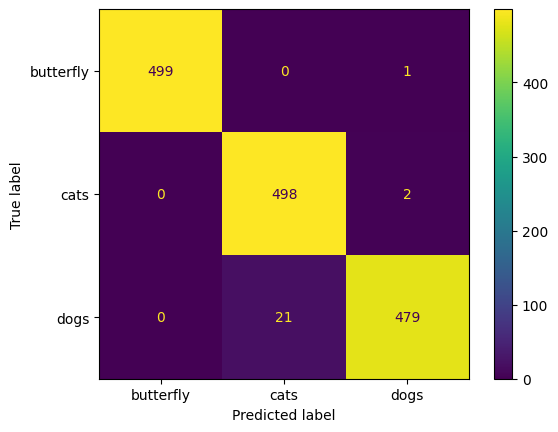

In [ ]:
y_pred = model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(cm, display_labels=test_set.class_indices)
disp.plot()

13. menampilkan Accuracy Training dan Valuation menggunakan plot yang menampilkan model stabil dengan accuracy 98%.

Kriteria 6: Membuat Plot Terhadap Akurasi dan Loss Model

akurasi nampak tidak stabil dalam plot dikarenakan range kecil yaitu 0.98-0.99 untuk accuracy dan 0.02-0.08 untuk Loss

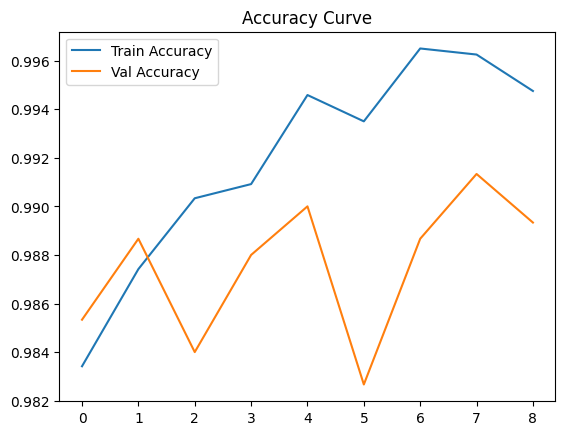

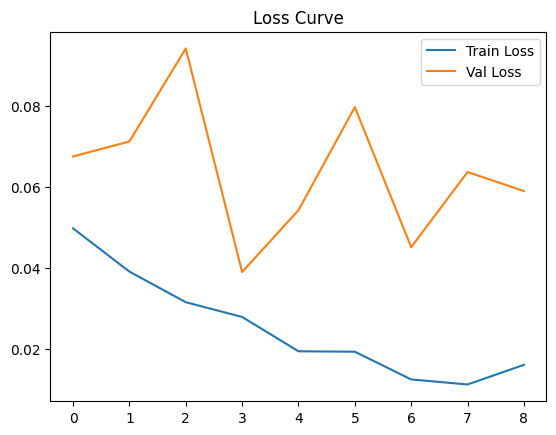

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

15. Simpan model sebagai : Saved model

Kriteria 7: Menyimpan Model ke Dalam Format SavedModel, TF-Lite dan TFJS

melakukan convert TFJS melalui command prompt

In [ ]:
# Setelah training selesai
model.export("saved_model/")

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2965958135648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2965958104336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2965958103808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2965958120896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2965958104512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2965958103456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2965958149040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2965958149920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2965958148160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2965958148688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2965958152032: TensorSpec(shape=(), d

In [ ]:
import tensorflow as tf

# Convert SavedModel ke TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/')
tflite_model = converter.convert()

# Simpan ke file
with open('saved_model.tflite', 'wb') as f:
    f.write(tflite_model)

14. Melakukan inference dengan model secara langsung untuk setiap kelas.

In [ ]:
# 1. Load gambar
img_path1 = 'bery_bangchan.jpg'
img_path2 = 'leeknow_dongie.jpg'
img_path3 = 'Beautiful_butterfly.jpg'

img1 = image.load_img(img_path1, target_size=(224, 224))
img2 = image.load_img(img_path2, target_size=(224, 224))
img3 = image.load_img(img_path3, target_size=(224, 224))

img_array1 = image.img_to_array(img1)
img_array1 = np.expand_dims(img_array1, axis=0)  # tambah batch dimensi
img_array1 = img_array1 / 255.0  # normalisasi

img_array2 = image.img_to_array(img2)
img_array2 = np.expand_dims(img_array2, axis=0)  # tambah batch dimensi
img_array2 = img_array2 / 255.0  # normalisasi

img_array3 = image.img_to_array(img3)
img_array3 = np.expand_dims(img_array3, axis=0)  # tambah batch dimensi
img_array3 = img_array3 / 255.0  # normalisasi

# 2. Inference
prediction1 = model.predict(img_array1)
prediction2 = model.predict(img_array2)
prediction3 = model.predict(img_array3)

# 3. Interpretasi (3 kelas)
classes = ['butterfly', 'cats', 'dogs']  # Sesuaikan dengan kelas yang ada pada model

# Prediksi untuk gambar 1
class_idx1 = np.argmax(prediction1)  # dapatkan index kelas dengan probabilitas tertinggi
confidence1 = prediction1[0][class_idx1]
print(f"Prediksi gambar 1: {classes[class_idx1]} ({confidence1:.2f} confidence)")

# Prediksi untuk gambar 2
class_idx2 = np.argmax(prediction2)  # dapatkan index kelas dengan probabilitas tertinggi
confidence2 = prediction2[0][class_idx2]
print(f"Prediksi gambar 2: {classes[class_idx2]} ({confidence2:.2f} confidence)")

# Prediksi untuk gambar 3
class_idx3 = np.argmax(prediction3)  # dapatkan index kelas dengan probabilitas tertinggi
confidence3 = prediction3[0][class_idx3]
print(f"Prediksi gambar 3: {classes[class_idx3]} ({confidence3:.2f} confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediksi gambar 1: dogs (1.00 confidence)
Prediksi gambar 2: cats (1.00 confidence)
Prediksi gambar 3: butterfly (1.00 confidence)


16. melakukan inference pada best model.h5

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

saved_model_path = 'best_model.h5'
model = tf.keras.models.load_model(saved_model_path)

# 1. Load gambar
img_path = 'bery_bangchan.jpg'
img = image.load_img(img_path, target_size=(224, 224))

# Mengubah gambar menjadi array dan normalisasi
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # tambah dimensi batch
img_array = img_array / 255.0  # normalisasi

# 2. Inference
prediction = model.predict(img_array)

# 3. Interpretasi
classes = ['butterfly', 'cats', 'dogs']  # Sesuaikan dengan kelas yang ada pada model
class_idx = np.argmax(prediction)  # Dapatkan index kelas dengan probabilitas tertinggi
confidence = prediction[0][class_idx]
print(f"Prediksi gambar: {classes[class_idx]} ({confidence:.2f} confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
Prediksi gambar: dogs (1.00 confidence)


18. melakukan inference menggunakan Saved model

Melakukan inference menggunakan salah satu model (TF-Lite, TFJS atau savedmodel).

Pastikan menyertakan bukti inferensi baik itu dalam bentuk screenshot atau output pada notebook

In [3]:
saved_model_path = './saved_model/saved_model/'  # Path ke model SavedModel
model = tf.saved_model.load(saved_model_path)

# 1. Load gambar
img_path = '/content/leeknow_dongie.jpg'
img = image.load_img(img_path, target_size=(224, 224))

# Mengubah gambar menjadi array dan normalisasi
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # tambah dimensi batch
img_array = img_array / 255.0  # normalisasi

# 2. Inference
# Mengambil signature prediksi
predict_fn = model.signatures["serving_default"]

# Melakukan prediksi
prediction = predict_fn(tf.convert_to_tensor(img_array))

# Menampilkan semua key yang ada dalam prediction untuk mengetahui output layer mana yang digunakan
print("Prediction keys:", prediction.keys())

# 3. Interpretasi
# Misalnya, jika output layer memiliki nama 'output_0', sesuaikan kode ini
classes = ['butterfly', 'cats', 'dogs']  # Sesuaikan dengan kelas yang ada pada model
output_name = list(prediction.keys())[0]  # Ambil nama key pertama yang tersedia dalam prediction
class_idx = np.argmax(prediction[output_name].numpy())  # Dapatkan index kelas dengan probabilitas tertinggi
confidence = prediction[output_name].numpy()[0][class_idx]
print(f"Prediksi gambar: {classes[class_idx]} ({confidence:.2f} confidence)")

Prediction keys: dict_keys(['output_0'])
Prediksi gambar: cats (1.00 confidence)


Tambahan bukti dikarenakan saya melakukan inference Saved_Mode di notebook yang berbeda.

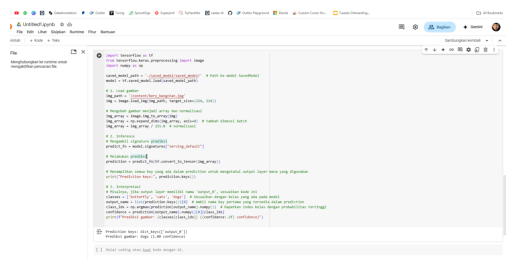

In [5]:
img = mpimg.imread('/content/Screenshot 2025-04-20 230726.png')
plt.imshow(img)
plt.axis('off')
plt.show()